In [11]:
import numpy as np
import matplotlib.pyplot as plt
import eleanor
import lightkurve as lk
import copy
import scipy.fftpack as sfft
from scipy.optimize import minimize
from scipy.ndimage import zoom
from skimage import restoration
import tqdm
from stemtool.afit import mpfit
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
eleanor.__file__

'/Users/adityasengupta/research/pals/photometry/eleanor/eleanor/__init__.py'

In [53]:
data.get_neighbors(tmag_cut=None)

,ra,dec,MatchID,MatchRa,MatchDEC,dstArcSec,version,HIP,TYC,UCAC,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,_selected_
0,284.926069,36.551035,120362128,284.926069,36.551035,0.000000,20190415,None,2651-00955-1,633-066280,...,None,9.134543,8.361725,284.926057,36.551144,0.252999,0.272779,1.0,0.0,False
1,284.926069,36.551035,1715322525,284.930611,36.551717,13.360298,20190415,None,None,None,...,None,5.586197,5.845042,284.930611,36.551692,0.170940,0.215533,1.0,0.0,False
2,284.926069,36.551035,1715322481,284.926138,36.545674,19.299984,20190415,None,None,None,...,None,22.860626,21.316692,284.926112,36.545650,0.720799,0.708794,1.0,1.0,False
3,284.926069,36.551035,1715322488,284.934029,36.547897,25.643267,20190415,None,None,None,...,None,13.844101,15.484200,284.934043,36.547896,0.418288,0.551405,1.0,0.0,False
4,284.926069,36.551035,120362137,284.921229,36.557565,27.359124,20190415,None,2651-00975-1,633-066276,...,None,1.000352,0.948238,284.921246,36.557557,0.029083,0.030437,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2326,284.926069,36.551035,1715321756,285.025782,36.443618,482.502705,20190415,None,None,None,...,None,5.965122,6.786733,285.025774,36.443577,0.158742,0.215002,1.0,0.0,False
2327,284.926069,36.551035,1715434556,284.886224,36.681257,482.730272,20190415,None,None,None,...,None,6.630392,6.322877,284.886208,36.681232,0.180514,0.195269,1.0,0.0,False
2328,284.926069,36.551035,120359536,284.807505,36.645482,482.735332,20190415,None,None,None,...,cooldwarfs_v8,47.108061,44.725019,284.807502,36.645471,0.257047,0.249972,1.0,0.0,False
2329,284.926069,36.551035,1715323467,285.080917,36.601257,482.800945,20190415,None,None,None,...,None,14.166010,15.637047,285.080923,36.601274,0.427042,0.583127,1.0,0.0,False


In [46]:
type(data.post_obj)

eleanor.postcard.Postcard_tesscut

In [3]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False

In [4]:
data = eleanor.TargetData(star, height=15, width=15, do_pca=True, do_psf=False)

In [8]:
data.cen_x

0

In [4]:
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
tpfs = sc.flux[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end]
bkg0 = np.mean(bkgs).value

In [5]:
xc = [4.9, 4.5, 4.7]
yc = [3.0, 4.4, 7.0]
aperture_fluxes = data.get_aperture_fluxes(xc=xc, yc=yc, data_arr=tpfs)

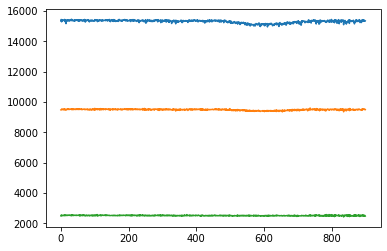

In [54]:
plt.plot(aperture_fluxes)

In [221]:
aperture_fluxes[0].shape

(3,)

In [225]:
# first, get the PSF and fit it to a single Gaussian or Moffat with individual drifts
def aperture_deltas(xc, yc, mags, bkg0=0):
    """
    Based on center information and aperture flux, 
    makes a model of what the TPF would look like with a deconvolved PSF.
    """
    deconv_tpf_model = np.zeros_like(tpfs) + bkg0
    for i, (x, y, m) in enumerate(zip(xc, yc, mags)):
        xl, yl, wts = data.cutout_weights(x, y)
        deconv_tpf_model[:, yl:yl+2, xl:xl+2] += m * np.array([f * wts for f in aperture_fluxes[:,i]])
    
    return deconv_tpf_model

deltas = aperture_deltas(xc, yc, aperture_fluxes[0], bkg0=bkg0)

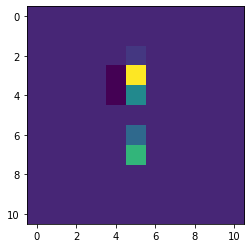

In [226]:
plt.imshow(deltas[0])

In [227]:
deltas_ft = np.array([sfft.fft2(d) for d in deltas])
tpfs_ft = np.array([sfft.fft2(t) for t in tpfs])
ft_ratios = np.array([sfft.fft2(tf / df) for tf, df in zip(tpfs_ft, deltas_ft)])
psfs = np.array([sfft.fftshift(r.real ** 2 + r.imag ** 2) for r in ft_ratios])

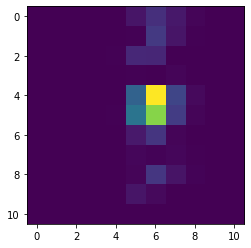

In [228]:
avg_psf = np.mean(psfs, axis=0) / np.mean(psfs)
plt.imshow(avg_psf)

In [237]:
y_grid, x_grid = np.mgrid[:11, :11]
log_avg_psf = np.log(avg_psf)

def psf(p):
    a, b, c, xs, ys = p
    dx = x_grid - xs
    dy = y_grid - ys
    return np.exp(-(a * dx ** 2 + 2 * b * dx * dy * c * dy ** 2))

def loss(p):
    # Gaussian, for now
    return np.sum((avg_psf - psf(p)) ** 2)

In [230]:
psfoptpars = minimize(loss, [1, 0, 1, 11 // 2 + 1, 11 // 2 + 1], method='Nelder-Mead').x

In [231]:
# I think this is overfitting and is also biased in some way i can't see yet, so leaving it aside for now

def drift_loss(pos, i):
    xs, ys = pos
    a, b, c, xo, yo = psfoptpars
    dx = x_grid - (xs + xo)
    dy = y_grid - (ys + yo)
    return np.sum((np.log(psfs[i]) + a * dx ** 2 + 2 * b * dx * dy * c * dy ** 2) ** 2)
    
xs, ys = np.zeros(len(tpfs)) + psfoptpars[3], np.zeros(len(tpfs)) + psfoptpars[4]
for i in tqdm.trange(len(tpfs)):
    drifts = minimize(drift_loss, [0, 0], i).x
    xs[i] += drifts[0]
    ys[i] += drifts[1]

100%|██████████| 900/900 [00:13<00:00, 67.02it/s]


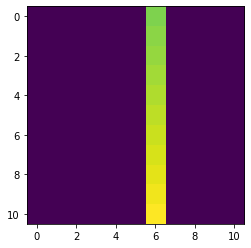

In [232]:
a, b, c, x_c, y_c = psfoptpars
dx = x_grid - x_c
dy = y_grid - y_c
plt.imshow(np.exp(-a * dx ** 2 - 2 * b * dx * dy - c * dy ** 2))

In [9]:
def fluxes_arma(kernel=np.array([1, 2, 4, 2, 1])):
    assert len(kernel) % 2 == 1, "must have a symmetric kernel"
    half_len = len(kernel) // 2
    # kernel = kernel / sum(kernel)
    model_fluxes = np.empty_like(aperture_fluxes)
    for i in range(aperture_fluxes.shape[1]):
        conv_result = np.convolve(kernel, aperture_fluxes[:,i])[2 * half_len:-2 * half_len]
        model_fluxes[:half_len,i] = aperture_fluxes[:half_len,i]
        model_fluxes[half_len:-half_len,i] = conv_result
        model_fluxes[-half_len:,i] = aperture_fluxes[-half_len,i]

    return model_fluxes

In [10]:
plt.plot(aperture_fluxes[:,0])
plt.plot(fluxes_arma()[:,0])

NameError: name 'aperture_fluxes' is not defined

In [245]:
def psf_deltas(xc, yc, mags):
    model_tpf = np.zeros_like(tpfs[0])
    for (x, y, m) in zip(xc, yc, mags):
        model_tpf += m * psf([a, b, c, x, y])
    return model_tpf

In [4]:
def make_model_tpfs(kernel):
    model_fluxes = fluxes_arma(np.array(kernel))
    return np.array([psf_deltas(xc, yc, mags) for mags in model_fluxes])

def tpf_loss(kernel):
    model_tpfs = make_model_tpfs(kernel)
    return np.sum((model_tpfs - tpfs) ** 2)

In [256]:
res = minimize(tpf_loss, np.ones(7,), method='Nelder-Mead', tol=1e-4)

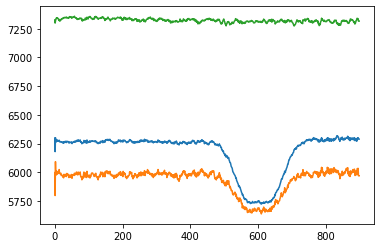

In [257]:
plt.plot(fluxes_arma(res.x))

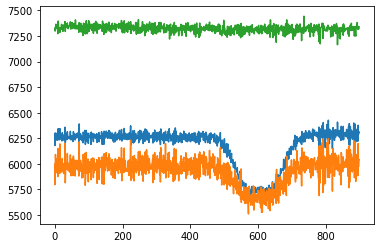

In [258]:
plt.plot(aperture_fluxes)

In [55]:
data.get_lightcurve()

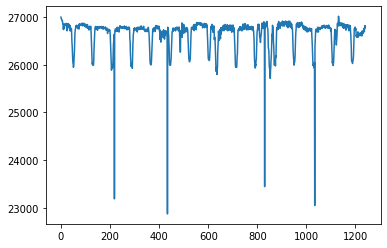

In [56]:
plt.plot(data.corr_flux)

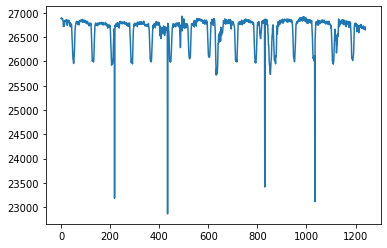

In [57]:
plt.plot(data.pca_flux)

In [58]:
data.corrected_flux()

masked_array(data=[26999.83743941, 26984.67899173, 26956.0520887 , ...,
                   26817.80109719, 26770.53224024, 26808.98098696],
             mask=False,
       fill_value=1e+20)

In [30]:
main_image = tpfs[0]
initial_peaks = np.array([yc, xc])
mpfit_peaks = mpfit(main_image, initial_peaks)

In [32]:
(len(tpfs), *initial_peaks.shape)

(900, 2, 3)

In [49]:
peaks = np.zeros((len(tpfs)//20, *initial_peaks.shape))
for i, tpf in enumerate(tqdm.tqdm(tpfs[::20])):
    peaks[i] = mpfit(tpf, initial_peaks)
    

100%|██████████| 45/45 [00:12<00:00,  3.62it/s]


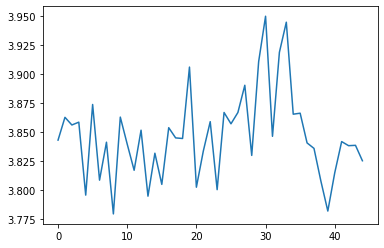

In [50]:
plt.plot(peaks[:,0,0])

In [52]:
y, x = initial_peaks

In [54]:
yc

[3.0, 4.4, 7.0]

In [28]:
mpfit(tpfs[0], initial_peaks)

array([[3.84312453, 4.17132834, 0.        ],
       [4.44006139, 4.43966579, 0.        ]])

In [44]:
np.any(np.isnan(tpfs))

False

In [5]:
data

In [16]:
data.psf_lightcurve()

  0%|          | 0/1241 [00:00<?, ?it/s]


ValueError: zero-size array to reduction operation minimum which has no identity